In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import torch
from torch.autograd import Variable
from torch.nn.init import normal, constant
from torch import nn
from matplotlib import pyplot as plt
# from attorch.train import early_stopping
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)

torch.cuda.empty_cache()


In [8]:
import numpy as np
import numpy.random as npr
import pandas as pd
from sklearn import preprocessing

from notebooks.imports import *
from config import dir_config
from src.utils.glm_hmm_utils import *
import pickle
import copy

In [9]:
from src.bayesian_encoding.model import Net
from src.bayesian_encoding.utils import set_seed

### Config

In [10]:
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)

In [14]:
# reject sessions
session_to_exclude = ["210210_GP_JP","241209_GP_TZ"]

session_metadata = pd.read_csv(Path(compiled_dir, "sessions_metadata.csv"))
neuron_metadata = pd.read_csv(Path(compiled_dir, "neuron_metadata.csv"))

session_metadata = session_metadata[~session_metadata["session_id"].isin(session_to_exclude)]
neuron_metadata = neuron_metadata[~neuron_metadata["session_id"].isin(session_to_exclude)]

with open(Path(processed_dir, "glm_hmm_all_trials_prior_based_initialization_final.pkl"), "rb") as f:
	glm_hmm = pickle.load(f)

with open(Path(processed_dir, "ephys_neuron_wise.pkl"), "rb") as f:
	ephys = pickle.load(f)

In [12]:
coh = [-50, -20, -6, 0, 6, 20, 50]

equal_prior = np.array([0.125, .125, .125, .25, .125, .125, .125])
toRF_prior = np.array([0.075, 0.075, 0.075, 0.25, 0.175, 0.175, 0.175])
awayRF_prior = np.array([0.175, 0.175, 0.175, 0.25, 0.075, 0.075, 0.075])

### Helper Functions

In [13]:
def get_session_neural_data(epoch, valid_trial_filter, neuron_ids):
	"""return 3d array of shape (num_neurons, num_trials, num_time_bins)"""
	neural_data = []
	for neuron_id in neuron_ids:
		neural_data.append(ephys[epoch][neuron_id]['convolved_spike_trains'])
	neural_data = np.array(neural_data)
	neural_data = neural_data[:, valid_trial_filter, :]
	return neural_data


### Aggregate Sessions

In [137]:
toRF_trial_freq_by_coh_and_prior = np.empty((len(session_metadata), 2, len(coh)))*np.nan
awayRF_trial_freq_by_coh_and_prior = np.empty((len(session_metadata), 2, len(coh)))*np.nan
# aggregate all sessions
for session_idx, session_id in enumerate(session_metadata.session_id):
	trial_data = glm_hmm['session_wise']['data'][session_id]
	valid_trial_filter = np.where((trial_data['mask'] == 1) & (~np.isnan(trial_data['reaction_time'])))[0]
	trial_data = trial_data.iloc[valid_trial_filter]
	trial_data_count = trial_data.groupby(['prob_toRF', 'stimulus']).size().reset_index(name='freq')

	if session_metadata[session_metadata["session_id"] == session_id].prior_direction.values[0] == "toRF":
		toRF_trial_freq_by_coh_and_prior[session_idx, :, :] = np.array(trial_data_count.freq).reshape(2, len(coh))
	elif session_metadata[session_metadata["session_id"] == session_id].prior_direction.values[0] == "awayRF":
		awayRF_trial_freq_by_coh_and_prior[session_idx, :, :] = np.array(trial_data_count.freq).reshape(2, len(coh))[::-1]

toRF_min_trial_per_condition = np.nanmin(toRF_trial_freq_by_coh_and_prior, axis=0).astype(int)
awayRF_min_trial_per_condition = np.nanmin(awayRF_trial_freq_by_coh_and_prior, axis=0).astype(int)
toRF_min_trial_per_condition, awayRF_min_trial_per_condition

(array([[ 48,  50,  43,  48,  47,  48,  47],
        [ 49,  49,  47,  86, 112, 112, 109]]),
 array([[50, 48, 47, 48, 49, 49, 49],
        [65, 62, 62, 45, 29, 31, 27]]))

In [196]:
epoch = 'response_onset'
agg_toRF_neuron_data = []
agg_awayRF_neuron_data = []

# randomly draw trials from each session
for session_idx, session_id in enumerate(session_metadata.session_id):
	trial_data = glm_hmm['session_wise']['data'][session_id]
	valid_trial_filter = np.where((trial_data['mask'] == 1) & (~np.isnan(trial_data['reaction_time'])))[0]
	trial_data = trial_data.iloc[valid_trial_filter]
	neuron_ids = neuron_metadata.neuron_id[neuron_metadata.session_id == session_id].values

	toRF_trial_indices = {'eq': [], 'uneq': []}
	awayRF_trial_indices = {'eq': [], 'uneq': []}

	# randomly draw n trials from each session
	for coh_idx, coh_val in enumerate(coh):
		equal_trials = np.where((trial_data['prob_toRF'] == 50) & (trial_data['stimulus'] == coh_val/100))[0]
		unequal_trials = np.where((trial_data['prob_toRF'] != 50) & (trial_data['stimulus'] == coh_val/100))[0]

		if session_metadata['prior_direction'].iloc[session_idx] == "toRF":
			toRF_trial_indices['eq'].append(npr.choice(equal_trials, size=toRF_min_trial_per_condition[0, coh_idx], replace=False))
			toRF_trial_indices['uneq'].append(npr.choice(unequal_trials, size=toRF_min_trial_per_condition[1, coh_idx], replace=False))

		elif session_metadata['prior_direction'].iloc[session_idx] == "awayRF":
			awayRF_trial_indices['eq'].append(npr.choice(equal_trials, size=awayRF_min_trial_per_condition[0, coh_idx], replace=False))
			awayRF_trial_indices['uneq'].append(npr.choice(unequal_trials, size=awayRF_min_trial_per_condition[1, coh_idx], replace=False))


	if session_metadata['prior_direction'].iloc[session_idx] == "toRF":
		all_trial_indices = np.hstack(toRF_trial_indices['eq'] + toRF_trial_indices['uneq'])
		agg_toRF_neuron_data.append(get_session_neural_data(epoch=epoch, valid_trial_filter=all_trial_indices, neuron_ids=neuron_ids))
	elif session_metadata['prior_direction'].iloc[session_idx] == "awayRF":
		all_trial_indices = np.hstack(awayRF_trial_indices['eq'] + awayRF_trial_indices['uneq'])
		agg_awayRF_neuron_data.append(get_session_neural_data(epoch=epoch, valid_trial_filter=all_trial_indices, neuron_ids=neuron_ids))

agg_toRF_neuron_data = np.vstack(agg_toRF_neuron_data)
agg_awayRF_neuron_data = np.vstack(agg_awayRF_neuron_data)
agg_toRF_neuron_data.shape, agg_awayRF_neuron_data.shape

((86, 895, 351), (81, 661, 351))

#### prior

In [193]:
prior_toRF = np.vstack((np.vstack([np.matlib.repmat(equal_prior,trial_num,1) for trial_num in toRF_min_trial_per_condition[0,:]]),
                       np.vstack([np.matlib.repmat(toRF_prior,trial_num,1) for trial_num in toRF_min_trial_per_condition[1,:]])))

prior_awayRF = np.vstack((np.vstack([np.matlib.repmat(equal_prior,trial_num,1) for trial_num in awayRF_min_trial_per_condition[0,:]]),
                       np.vstack([np.matlib.repmat(awayRF_prior,trial_num,1) for trial_num in awayRF_min_trial_per_condition[1,:]])))

#### t

In [194]:
t_toRF = np.repeat([coh,coh],toRF_min_trial_per_condition.flatten())

t_awayRF = np.repeat([coh,coh],awayRF_min_trial_per_condition.flatten())

### toRF session fit

---

In [202]:
stim_map = {stim: i for i, stim in enumerate(np.sort(coh))}

x = torch.tensor(np.nansum(agg_toRF_neuron_data[:, :, 200:300], axis=2).T, dtype=torch.float32, device="cuda")
t = torch.tensor([stim_map[stim] for stim in t_toRF], dtype=torch.long, device="cuda")
prior = torch.tensor(prior_toRF, dtype=torch.float32, device="cuda")

In [205]:
net = Net(n_channel=x.shape[1], n_output=len(coh), n_hidden=[500,500], std=0.001, dropout=0.5)
net.cuda()
loss = nn.CrossEntropyLoss().cuda()
net.eval()

Net(
  (hiddens): Sequential(
    (0): Linear(in_features=86, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (ro_layer): Linear(in_features=500, out_features=7, bias=True)
)

1.9949657310731992


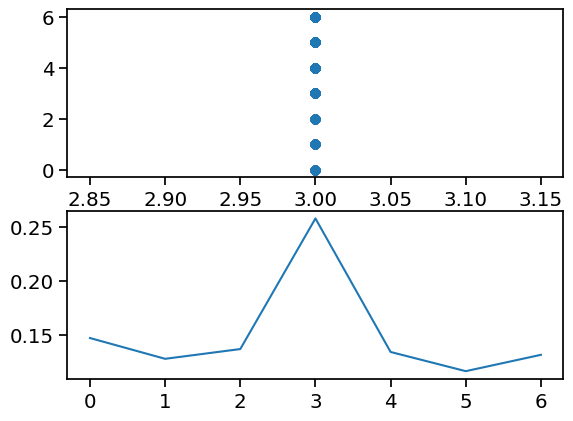

In [207]:
delta = 1
net.eval()
y = net(x)
y = y + prior
val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()


plt.subplot(211)
t_hat = idx.data.cpu().numpy()
plt.scatter(t_hat, t.cpu().numpy())

print(np.sqrt(np.mean((t_hat - t.cpu().numpy())**2)) * delta)

plt.subplot(212)

plt.plot(yd[47])

In [218]:
net.std = 1e-2
set_seed(8)
net.initialize()
torch.autograd.set_detect_anomaly(True)

# Learning rates
alpha = 1  # Reduce regularization term
learning_rates = 0.003 * 3.0**(-np.arange(3))  # Reduced learning rates

for lr in learning_rates:
    print('\n\n\n\n LEARNING RATE: {}'.format(lr))
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)

    for epoch in range(1000):
        net.train()
        optimizer.zero_grad()

        y = net(x)

        # Check for NaNs in output
        if torch.isnan(y).any() or torch.isinf(y).any():
            print(f"NaNs or Infs detected in output y at epoch {epoch}")
            print(f"Output y range: min={y.min()}, max={y.max()}, mean={y.mean()}")
            break

        post = y + prior
        post = post - post.max(1, keepdim=True)[0]  # Stabilize softmax

        # Check for NaNs in post
        if torch.isnan(post).any() or torch.isinf(post).any():
            print(f"NaNs or Infs detected in post at epoch {epoch}")
            break

        conv_filter = torch.tensor([-0.25, 0.5, -0.25], dtype=torch.float32, device="cuda").reshape(1, 1, -1)
        smoothness = nn.functional.conv1d(y.unsqueeze(1), conv_filter).pow(2).mean()

        score = loss(post, t) + alpha * smoothness

        # Check for NaNs in loss score
        if torch.isnan(score).any() or torch.isinf(score).any():
            print(f"NaNs or Infs detected in loss at epoch {epoch}")
            break

        score.backward()

        # Check gradients for NaNs
        for param in net.parameters():
            if torch.isnan(param.grad).any():
                print("NaNs detected in gradients")
                break

        # # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)  # You can experiment with max_norm

        optimizer.step()

        if epoch % 100 == 0:
            print(f'Score: {score.item()}')


Setting numpy and torch seed to 8




 LEARNING RATE: 0.003
Score: 314.5189514160156
Score: 17.081615447998047
Score: 3.907456636428833
Score: 2.08846378326416
Score: 1.8062961101531982
Score: 1.6824371814727783
Score: 1.6057783365249634
Score: 1.5085606575012207
Score: 1.4776110649108887
Score: 1.3538670539855957




 LEARNING RATE: 0.001
Score: 1.3336458206176758
Score: 1.3048834800720215
Score: 1.2924487590789795
Score: 1.2561935186386108
Score: 1.2566490173339844
Score: 1.2380380630493164
Score: 1.2417078018188477
Score: 1.1753997802734375
Score: 1.1846925020217896
Score: 1.1965410709381104




 LEARNING RATE: 0.0003333333333333333
Score: 1.167478084564209
Score: 1.1698790788650513
Score: 1.1374306678771973
Score: 1.1690256595611572
Score: 1.1611974239349365
Score: 1.1359902620315552
Score: 1.151733160018921
Score: 1.1271791458129883
Score: 1.1256457567214966
Score: 1.1274062395095825


In [209]:
def objective(net, x=None, t=None):
	if x is None and t is None:
		return None
	net.eval()
	y = net(x)
	posterior = y + prior
	_, loc = torch.max(posterior, dim=1)
	v =(t.double() - loc.double()).pow(2).mean().sqrt() * delta
	return v.data.cpu().numpy()

objective(net, x=x, t=t)

array(0.54414096)

In [210]:
nbins = 7
pv = (np.arange(nbins) - nbins//2) * delta
t_ = t.cuda().cpu().numpy()

In [211]:
pv

array([-3, -2, -1,  0,  1,  2,  3])

In [212]:
t[11]

tensor(0, device='cuda:0')

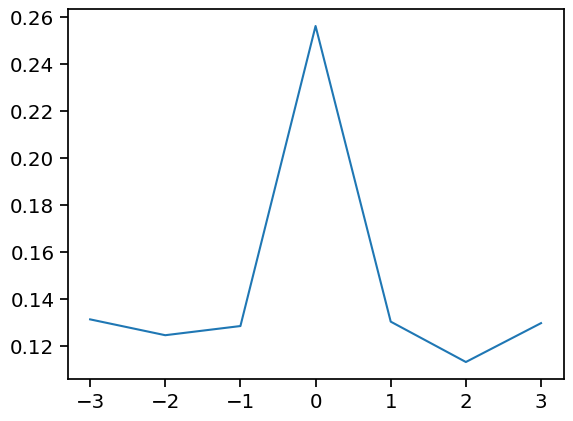

In [213]:
plt.plot(pv, yd[11])

Text(0.5, 0.98, '$\\mathbf{E}[\\sigma]$=1.418')

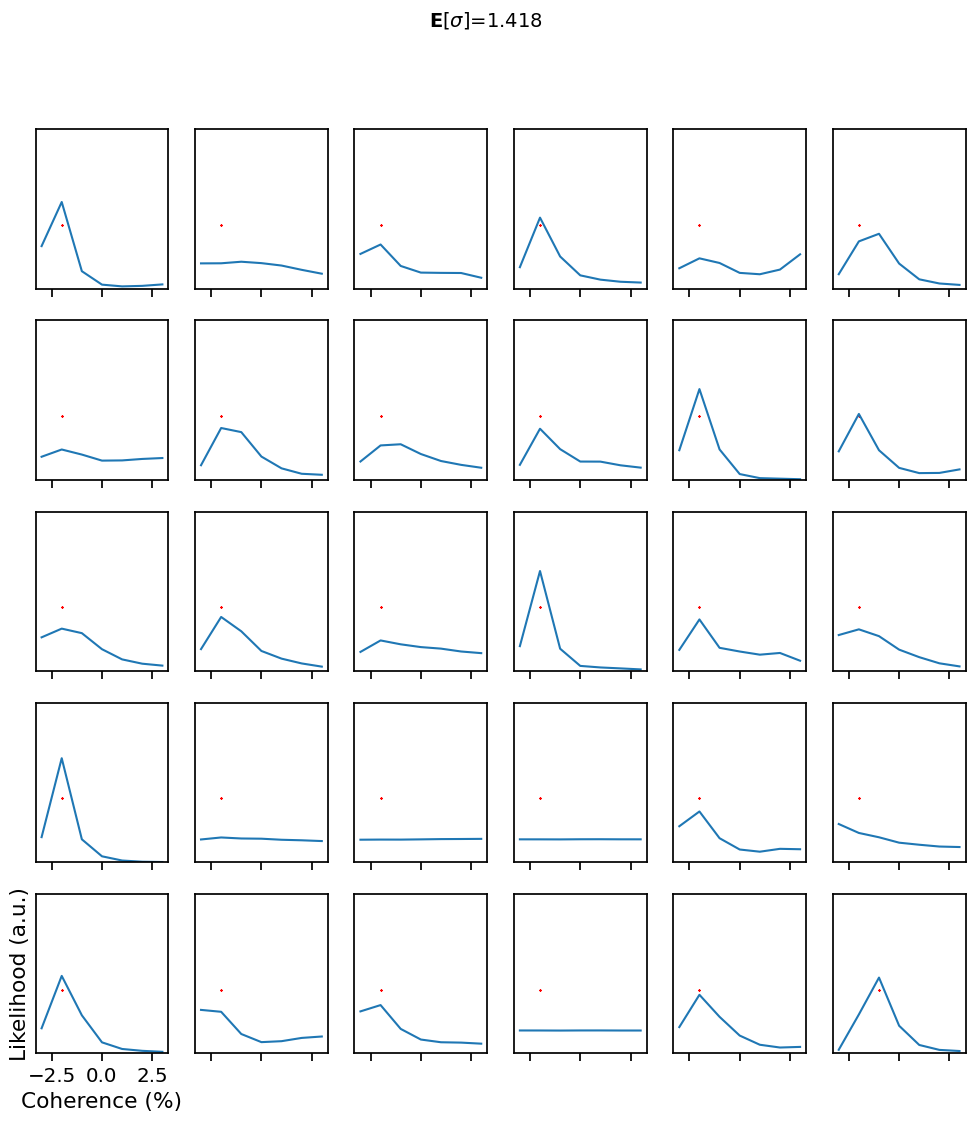

In [215]:

from itertools import count

y = net(x)
#val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()
yd = np.exp(yd)
yd = yd / yd.sum(axis=1, keepdims=True)

loc = yd.argmax(axis=1)
ds = (np.arange(nbins) - loc[:, None])**2

avg_sigma = np.mean(np.sqrt(np.sum(yd * ds, axis=1))) * delta

n_rows = 5
n_cols = 6
fig, axs = plt.subplots(5, 6, figsize=(12, 12))

for c, ((i, j), ax) in zip(count(), np.ndenumerate(axs)):
    c = c+400

    ax.plot(pv, yd[c])
    ax.scatter(pv[t_[c]],0.4, color='red', marker='x', s=1)
    ax.set_ylim([0, 1])
    ax.set_yticks([])
    if j == 0 and i == n_rows-1:
        ax.set_ylabel('Likelihood (a.u.)')
        ax.set_xlabel('Coherence (%)')#($^\circ$)')
    else:
        ax.set_xticklabels([])

fig.suptitle("$\mathbf{{E}}[\sigma]$={:0.3f}".format(avg_sigma), fontsize=14)